# Make a dictionary combining the results of the three programs
**Objective**: Integrate the results of OneCodeToFindThemAll, LTRHarvest and TransposonPSI, eliminating overlaps.  
**Inputs**: 

+ `.elem_store` files from the `OneCodeToFindThemAll` directory.
+ `.output` files from the `LTRHarvest` directory.
+ `.bestPerLocus` files from the `TransposonPSI` direcotry.
+ `18S_tree/18S_tree_reprophylo_project_v2` a pickeled `Project`

**Output**: 

+ `TE_counts/TEs.pkl` a dictionary with species codes as keys and TE dictionaries (see demonstration below) as values.
+ `TE_counts/class_counts.pkl` a dictionary with species codes as keys and dictionaries with class level counts as values.
+ `TE_counts/family_counts.pkl` a dictionary with species codes as keys and dictionaries with superfamily level counts as values.
+ `TE_counts/family_counts.csv` a table with species as rows and classes+superfamiles as columns, containing counts.
+ `TE_counts/18S_tree_reprophylo_project_with_TE` a pickled `Project` containing class and superfamily counts as feature qualfiers.  

**Strategy**:  

+ Make a dictionary with `taken` and `discarded` keyes for each species. Put all the `OneCode` TEs in `taken`. If there are overlapping `OneCode` TEs, take only the highest scoring and put the rest in `discarded`.
+ Add LTRHarvest matches to `taken` if they are at least 80% identical to the query and at least 2000 bp long, and if they are longer than overlapping TEs that are already in taken (move the latter to `discarded`).
+ Add TransposonSPI matches to `taken` if they have a score of at least 80, and if they are longer than overlapping TEs that are already in taken (move the latter to `discarded` if there are any).
 

## Demonstration (not actual data)  
###Read the `OneCode` results

In [37]:
import TE
TEs, serial = TE.parse_ocfa_elem_stored('./OneCodeToFIndThemAll/%s/'%'Pred')

The `TEs` dict has a 'discarded' key which is empty and a 'taken' key that has all the TEs from OneCode. For example:

In [42]:
print 'TAKEN'
for l in str(TEs['taken'])[:1000].splitlines():
    print l
print '...'
print 'DISCARDED'
print str(TEs['discarded'])

TAKEN
{'element631': {'lower_tx_level': 'element630', 'end': 115613, 'higher_tx_level': 'LINE/R2-NeSL', 'start': 115314, 'length': 300, 'contig': 'Pred_495', 'ref': {'record': '###2789\t0.0\t0.0\t0.0\tPred_495\t115314\t115613\t300\tC\tPRED_RND-4_FAMILY-3400\tLINE/R2-NeSL\t(0)\t614\t315\t\t1\t0.489\n', 'program': 'RMOCFA'}}, 'element808': {'lower_tx_level': 'element805', 'end': 359523, 'higher_tx_level': 'SINE?', 'start': 359442, 'length': 82, 'contig': 'Pred_543', 'ref': {'record': '###505\t9.8\t0.0\t0.0\tPred_543\t359442\t359523\t82\tC\tSVEN_RND-4_FAMILY-740\tSINE?\t(523)\t5832\t5751\t*\t1\t0.013\n', 'program': 'RMOCFA'}}, 'element809': {'lower_tx_level': 'element805', 'end': 383483, 'higher_tx_level': 'DNA/hAT', 'start': 383402, 'length': 83, 'contig': 'Pred_543', 'ref': {'record': '###456\t14.6\t1.2\t0.0\tPred_543\t383402\t383483\t83\t+\tPRED_RND-4_FAMILY-1661\tDNA/hAT\t1\t83\t(248)\t\t1\t0.251\n', 'program': 'RMOCFA'}}, 'element146': {'lower_tx_level': 'element141', 'end': 205677, 

### Read `LTRHarvest` results
If they have less than 80% identity with their query or are shorter than 2000 bp, we ignore them. If they occupy a locus that was not detected by OneCode, we take them. If they overlapp with a locus that was detected also by `OneCode` and they are longer, we take them and chuck the `OneCode` locus into 'discarded'. If they are worse than the OneCode match, we chuck the LTRharvest match to 'discarded'.  

In [24]:
TEs, serial = TE.integrate_ltrharvest_to_RM_TEs('LTRHarvest/Pred/Pred_ltrharvest.output',
                                                '/media/amir/DATA/work/Dropbox/Genomes/Panagrellus_redivivus.KB454917-KB455574.fasta_coded.fasta',
                                                        TEs,serial,
                                                        sim_cutoff=80,
                                                        l_cutoff=2000) 

To demonstrate, here is a discarded match:

In [25]:
TEs['discarded'][TEs['discarded'].keys()[0]]

{'contig': 'Pred_616',
 'end': 846019,
 'higher_tx_level': 'DNA/PiggyBac',
 'length': 629,
 'lower_tx_level': 'element764',
 'ref': {'program': 'RMOCFA',
  'record': '###4695\t8.1\t0.2\t0.6\tPred_616\t845388\t846019\t629\tC\tPRED_RND-3_FAMILY-303\tDNA/PiggyBac\t(1)\t630\t2\t\t1\t0.997\n'},
 'start': 845388}

We expect to find a 'taken' match which overlaps this one and is also better than this one.  
**This looks for a discarded match that overlapps the taken one above, and finds it:**

In [27]:
for e in TEs['taken'].keys():
    # same contig?
    if (TEs['taken'][e]['contig'] == 'Pred_616' and 
          # overlapp?
         (845388<TEs['taken'][e]['start']<846019 or 
          845388<TEs['taken'][e]['end']<846019 or 
          TEs['taken'][e]['start']<845388<TEs['taken'][e]['end'] or 
          TEs['taken'][e]['start']<846019<TEs['taken'][e]['end']
          )):
        
        print TEs['taken'][e]

{'lower_tx_level': '?', 'end': 850002, 'higher_tx_level': 'LTR', 'start': 838367, 'length': 11636, 'contig': 'Pred_616', 'ref': {'record': '838367  850002  11636  838367  838683  317  849680  850002  323  88.54  615\n', 'program': 'LTRharvest'}}


It indeed found an overlapping match that is longer in the 'taken' key.

### Read TransposonPSI results
If they occupy a locus that was not detected before, we take them. If they overlapp with a locus that was detected before and they are longer, we take them and chuck the preexisitng match into 'discarded'. If they are worse than the previous match, we chuck the TransposonPSI match to 'discarded'.  

In [28]:
TPSI_path = './TransposonPSI/%s/%s_coded.fasta.TPSI.allHits.chains.bestPerLocus'%('Pred',
                                                                       TE.genomes_dict('Genomes/',
                                                                                       code_file='genome_assembly_files_v3.csv')['Pred'])
TEs = TE.integrate_TransposonPSI_to_RM_TEs(TPSI_path,'Genomes/', TEs, serial, score_cutoff=80)

Here is a discarded TransposonPSI match:

In [30]:
[TEs['discarded'][e] for e in TEs['discarded'].keys() if TEs['discarded'][e]['ref']['program'] =='TransposonPSI'][0]

{'contig': 'Pred_576',
 'end': 43950,
 'higher_tx_level': 'LINE',
 'length': 909,
 'lower_tx_level': '?',
 'ref': {'program': 'TransposonPSI',
  'record': '#Chain\tLINE\t494-806\tPred_576\t43042-43950\t-\t65.7\n'},
 'start': 43042}

And the overlapping element that was better, in the taken key:

In [31]:
for e in TEs['taken'].keys():
    # same contig?
    if (TEs['taken'][e]['contig'] == 'Pred_576' and 
          # overlapp?
         (43042<TEs['taken'][e]['start']<43950 or 
          43042<TEs['taken'][e]['end']<43950 or 
          TEs['taken'][e]['start']<845388<TEs['taken'][e]['end'] or 
          TEs['taken'][e]['start']<43042<TEs['taken'][e]['end']
          )):
        
        print TEs['taken'][e]

{'lower_tx_level': 'element960', 'end': 43439, 'higher_tx_level': 'LINE/CR1', 'start': 42451, 'length': 994, 'contig': 'Pred_576', 'ref': {'record': '###8585\t2.1\t0.5\t0.0\tPred_576\t42451\t43439\t994\tC\tPRED_RND-4_FAMILY-484\tLINE/CR1\t(0)\t1010\t17\t\t1\t0.984\n', 'program': 'RMOCFA'}}


## Read the real data

In [5]:
import TE, os

# A dictionary with species codes as keys and TE dictionaries as values (see TE dictionary above)
All_SP_TEs = {}

for code in TE.genomes_dict('Genomes/', code_file='genome_assembly_files_v3.csv'):
    if os.path.exists('RepeatMasker/%s/%s_coded.fasta.out'%(code,TE.genomes_dict('Genomes/',
                                                                                 code_file='genome_assembly_files_v3.csv')[code])):
        # Read OneCode
        TEs, serial = TE.parse_ocfa_elem_stored('./OneCodeToFIndThemAll/%s/'%code) 
        
        # Read LTRHarvest
        LTRH_path = 'LTRHarvest/'+code+'/'+code+'_ltrharvest.output'
        path = './../../'
        infasta = path+'Genomes/'+TE.genomes_dict('Genomes/',
                                            code_file='genome_assembly_files_v3.csv')[code]
        log = infasta+'_coded.log'
        outfasta = infasta+'_coded.fasta'
        if not os.path.exists(outfasta):
            TE.code_sequence_ids(infasta, log, outfasta, code)
        genome = path+'Genomes/'+TE.genomes_dict('Genomes/',
                                            code_file='genome_assembly_files_v3.csv')[code]+'_coded.fasta'
        
        TEs, serial = TE.integrate_ltrharvest_to_RM_TEs(LTRH_path,genome,
                                                        TEs,serial,
                                                        sim_cutoff=80,
                                                        l_cutoff=2000) 
        
        # Read TransposonPSI
        TPSI_path = './TransposonPSI/%s/%s_coded.fasta.TPSI.allHits.chains.bestPerLocus'%(code,
                                                                       TE.genomes_dict('Genomes/',
                                                                                       code_file='genome_assembly_files_v3.csv')[code])
        
        TEs = TE.integrate_TransposonPSI_to_RM_TEs(TPSI_path,path+'Genomes/', TEs, serial, score_cutoff=80)
        
        All_SP_TEs[code] = TEs

## compress OneCode results

In [7]:
import tarfile, TE, shutil, os

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:bz2") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

for code in TE.genome_codes_list('Genomes/', code_file='genome_assembly_files_v3.csv'):
    source_dir = './OneCodeToFIndThemAll/%s'%code
    output_filename = './OneCodeToFIndThemAll/%s.tar.bz2'%code
    make_tarfile(output_filename, source_dir)
    shutil.rmtree(source_dir)

## Correct high taxonomy
Make sure that different programs use the same name for the same element.
### List all the unique high level TE taxa in all the species

In [10]:
tax = []
for code in All_SP_TEs:
    for e in All_SP_TEs[code]['taken']:
        tax.append(All_SP_TEs[code]['taken'][e]['higher_tx_level'])
set(tax)

{'Crypton',
 'DDE_1',
 'DNA',
 'DNA/CMC-Chapaev',
 'DNA/CMC-Chapaev-3',
 'DNA/CMC-EnSpm',
 'DNA/CMC-Mirage',
 'DNA/CMC-Transib',
 'DNA/Crypton',
 'DNA/Dada',
 'DNA/EnSpm/CACTA',
 'DNA/Ginger',
 'DNA/Ginger2',
 'DNA/Helitron',
 'DNA/Kolobok-Hydra',
 'DNA/Kolobok-T2',
 'DNA/MULE-MuDR',
 'DNA/MULE-NOF',
 'DNA/Mariner',
 'DNA/Maverick',
 'DNA/Merlin',
 'DNA/MuDR',
 'DNA/MuLE-MuDR',
 'DNA/Novosib',
 'DNA/PIF-Harbinger',
 'DNA/PIF-ISL2EU',
 'DNA/PiggyBac',
 'DNA/RC',
 'DNA/Sola',
 'DNA/TcMar',
 'DNA/TcMar-Ant1',
 'DNA/TcMar-Fot1',
 'DNA/TcMar-IS630',
 'DNA/TcMar-ISRm11',
 'DNA/TcMar-Mariner',
 'DNA/TcMar-Pogo',
 'DNA/TcMar-Tc1',
 'DNA/TcMar-Tc2',
 'DNA/TcMar-Tc4',
 'DNA/TcMar-Tigger',
 'DNA/TcMar-m44',
 'DNA/Zator',
 'DNA/hAT',
 'DNA/hAT-Ac',
 'DNA/hAT-Blackjack',
 'DNA/hAT-Charlie',
 'DNA/hAT-Pegasus',
 'DNA/hAT-Tag1',
 'DNA/hAT-Tip100',
 'DNA/hAT-hAT5',
 'DNA/hAT-hATw',
 'DNA/hAT-hATx',
 'DNA/hAT-hobo',
 'DNA/piggyBac',
 'ISC1316',
 'ISa',
 'ISb',
 'LINE',
 'LINE/CR1',
 'LINE/CR1-Zenon',
 

### Synonymize names where needed:

In [6]:
corrections = {  'Crypton': 'YR/Crypton',
                 'DNA/Crypton': 'YR/Crypton',
                 'DDE_1': 'DNA/Unclassified',
                 'DNA': 'DNA/Unclassified',
                 'DNA/CMC-Chapaev': 'DNA/Chapaev',
                 'DNA/CMC-EnSpm': 'DNA/EnSpm',
                 'DNA/CMC-Transib':'DNA/Transib',
                 'DNA/EnSpm/CACTA': 'DNA/EnSpm',
                 'DNA/MULE-MuDR': 'DNA/MuLE-MuDR',
                 'DNA/MuDR': 'DNA/MuLE-MuDR',
                 'DNA/RC': 'DNA/Helitron',
                 'DNA/Mariner': 'DNA/TcMar-Mariner',
                 'ISC1316': 'DNA/ISC1316',
                 'ISa': 'DNA/ISa',
                 'ISb': 'DNA/ISb',
                 'LINE': 'LINE/Unclassified',
                 'SINE': 'SINE/Unclassified',
                 'LTR': 'LTR/Unclassified',
                 'LTR/Ngaro': 'YR/Ngaro',
                 'LTR/Viper': 'YR/Viper',
                 'LTR/DIRS': 'YR/DIRS',
                 'MuDR_A_B': 'DNA/MuLE-MuDR',
                 'P_element': 'DNA/P_element',
                 'TY1_Copia':'LTR/Copia',
                 'cacta': 'DNA/EnSpm',
                 'gypsy': 'LTR/Gypsy',
                 'hAT': 'DNA/hAT',
                 'helitronORF': 'DNA/Helitron',
                 'ltr_Roo': 'LTR/Roo',
                 'mariner': 'DNA/TcMar-Mariner',
                 'mariner_ant1': 'DNA/TcMar-Ant1',
                 'piggybac': 'DNA/PiggyBac',
                 'piggyBac': 'DNA/PiggyBac',
                 'DNA/piggyBac': 'DNA/PiggyBac',
                 'DNA/MULE-NOF': 'DNA/MuLE-NOF'}

### Apply the synonyms

In [7]:
for sp in All_SP_TEs:
    for e in All_SP_TEs[sp]['taken']:
        if All_SP_TEs[sp]['taken'][e]['higher_tx_level'] in corrections.keys():
            All_SP_TEs[sp]['taken'][e]['higher_tx_level'] = corrections[All_SP_TEs[sp]['taken'][e]['higher_tx_level']]

## Save the TE dictionary

In [8]:
import cloud.serialization.cloudpickle as pickle
if not os.path.exists('TE_counts'):
    os.mkdir('TE_counts')
pickle_file_name = 'TE_counts/TEs.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(All_SP_TEs, output)
output.close()

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


In [1]:
# read the dictionary in the next day
import cloud.serialization.cloudpickle as pickle
pickle_handle = open('TE_counts/TEs.pkl', 'rb')
All_SP_TEs = pickle.pickle.load(pickle_handle)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


### Count the TEs at the class level

In [9]:
class_counts = {}
for code in All_SP_TEs:
    counts = {}
    for i in [All_SP_TEs[code]['taken'][e]['higher_tx_level'].split('/')[0] for e in All_SP_TEs[code]['taken'].keys()]:
        if not i in counts.keys():
            counts[i] = 0
        counts[i] += 1
    class_counts[code] = counts
#class_counts

In [10]:
import cloud.serialization.cloudpickle as pickle
import os
if not os.path.exists('TE_counts'):
    os.mkdir('TE_counts')
pickle_file_name = 'TE_counts/class_counts.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(class_counts, output)
output.close()

### Count the TEs at the superfamily level

In [11]:
familiy_counts = {}
for code in All_SP_TEs:
    counts = {}
    for i in [All_SP_TEs[code]['taken'][e]['higher_tx_level'] for e in All_SP_TEs[code]['taken'].keys()]:
        if not i in counts.keys():
            counts[i] = 0
        counts[i] += 1
    familiy_counts[code] = counts
#familiy_counts

In [12]:
import cloud.serialization.cloudpickle as pickle
if not os.path.exists('TE_counts'):
    os.mkdir('TE_counts')
pickle_file_name = 'TE_counts/family_counts.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(familiy_counts, output)
output.close()

### Write a CSV with the family level counts (It is not used downstreem, it is just for inspection)

In [3]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'TE_counts/family_counts.pkl'
output = open(pickle_file_name,'rb')
familiy_counts = pickle.pickle.load(output)
output.close()

from itertools import chain
import csv
from reprophylo import view_csv_as_table

families = sorted([i for i in set(chain(*[familiy_counts[key].keys() for key in familiy_counts.keys()])) 
                   if not '?' in i])


sps = sorted([i for i in familiy_counts])
with open('TE_counts/family_counts.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['family'] + sps)
    for f in families:
        row = [f]
        for sp in sps:
            if f in familiy_counts[sp].keys():
                row.append(familiy_counts[sp][f])
            else:
                row.append(0)
        writer.writerow(row)
        

#view_csv_as_table('TE_counts/family_counts.csv','\t')
exclude = ['Acan', 'Asim', 'Bpah', 'Btim', 'Ever', 'Sbat', 'Tcan']

sps = sorted([i for i in familiy_counts if not i in exclude])
with open('TE_counts/family_counts_no_wtsi.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['family'] + sps)
    for f in families:
        row = [f]
        for sp in sps:
            if f in familiy_counts[sp].keys():
                row.append(familiy_counts[sp][f])
            else:
                row.append(0)
        writer.writerow(row)

### Mount the TE counts onto the ReproPhylo Project

In [14]:
from reprophylo import *
import cloud.serialization.cloudpickle as pickle

pj = unpickle_pj('18S_tree/18S_tree_reprophylo_project_v2', git=False)

pickle_handle = open('TE_counts/class_counts.pkl', 'rb')
class_counts = pickle.pickle.load(pickle_handle)
pickle_handle = open('TE_counts/family_counts.pkl', 'rb')
familiy_counts  = pickle.pickle.load(pickle_handle)  

for r in pj.records:
    for f in [i for i in r.features if not i.type == 'source']:
        if 'keep' in f.qualifiers.keys() and f.qualifiers['keep'][0] in class_counts.keys():
            sp = f.qualifiers['keep'][0]
            TEs = class_counts[sp]
            TEs.update(familiy_counts[sp])
            for e in TEs:
                f.qualifiers[e] = [TEs[e]]
pj.propagate_metadata()

In [15]:
pickle_pj(pj, 'TE_counts/18S_tree_reprophylo_project_with_TE')

'TE_counts/18S_tree_reprophylo_project_with_TE'

In [108]:
sorted_columns

[['Hbak', 42],
 ['Ebre', 45],
 ['Rcul', 47],
 ['Cjap', 48],
 ['Cbre', 49],
 ['C5sp', 50],
 ['Hduj', 51],
 ['Crem', 53],
 ['Ooch', 54],
 ['Ppac', 55],
 ['briC', 55],
 ['Cang', 56],
 ['Cele', 56],
 ['Bmal', 57],
 ['Gpal', 57],
 ['Asuu', 58],
 ['Gros', 58],
 ['Hcon', 58],
 ['C11sp', 59],
 ['Ovol', 59],
 ['Dimm', 60],
 ['Mflo', 61],
 ['Wban', 61],
 ['Mchi', 62],
 ['Minc', 64],
 ['Mjav', 64],
 ['Dviv', 65],
 ['Lloa', 65],
 ['Mhap', 65],
 ['Otip', 67],
 ['Eela', 68],
 ['Rsim', 68],
 ['Tmur', 68],
 ['Tspi', 68],
 ['Ttri', 68],
 ['Avit', 70],
 ['Bxyl', 70],
 ['Haor', 70],
 ['Lsig', 72],
 ['Smur', 73],
 ['Pred', 74],
 ['Spap', 77],
 ['Pcof', 78],
 ['Sven', 80],
 ['Hbac', 81],
 ['Ptri', 82],
 ['Srat', 86]]

In [ ]:
import pandas as pd
import numpy as np
from reprophylo import *

pj = unpickle_pj('18S_tree/18S_tree_reprophylo_project_v2', git=False)

TEs = pd.read_table('TE_counts/family_counts_no_wtsi.csv', index_col=0)

t = pj.ft('18S@SINA@gappyout@dna_cat_gtr')
t.dist = 0
t.ladderize()
t.set_outgroup(t.search_nodes(keep='Acal')[0])
t = t.get_common_ancestor(t.search_nodes(keep='Hduj')[0],t.search_nodes(keep='Cele')[0]).detach()
for l in t:
    if not l.keep in TEs:
        l.delete()
sorted_headers = [l.keep for l in t.get_leaves()]
TEs = pd.read_table('TE_counts/family_counts_no_wtsi.csv', index_col=0)

sorted_TEs = TEs[sorted_headers.pop(0)]

for head in sorted_headers:
    if head in TEs:
        sorted_TEs = pd.concat([sorted_TEs, TEs[head]], axis=1)
    
sorted_rows = sorted([[ind, list(row.values).count(0)] for ind,row in TEs.iterrows()], key=lambda i: i[1])
sorted_ind = [i[0] for i in sorted_rows]


TEs = sorted_TEs.ix[sorted_ind]

for ind, row in TEs.iterrows():
    for head in TEs:
        if TEs.ix[ind,head] > 0:
            TEs.ix[ind,head] = 1

%matplotlib inline

import numpy as np

def hinton(matrix, max_weight=0, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w == 0 else 'black'
        size = 0.3
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    #ax.autoscale_view()
    ax.invert_yaxis()
    
hinton(TEs)

for ind, row in TEs.iterrows():
    sps = []
    for sp in TEs:
        if row[sp] == 1:
            sps.append(sp)
    if len(sps) == 0:
        continue
    leaves = [t.search_nodes(keep=sp)[0].name for sp in sps]
    try:
        t.get_common_ancestor(leaves).addtefam += 1
    except:
        t.get_common_ancestor(leaves).add_feature('addtefam', 1)
            
for n in t.traverse():
    parents = n.get_ancestors()
    cumulative_fams = 0
    for p in parents:
        try:
            comulative_fams += 
    if n.is_leaf():
        n.add_face(TextFace(str(n.source_organism), fgcolor='blue'),0, position='branch-right')
    try:
        n.add_face(TextFace(str(n.addtefam), fgcolor='blue'),0, position='float')
    except:
        pass

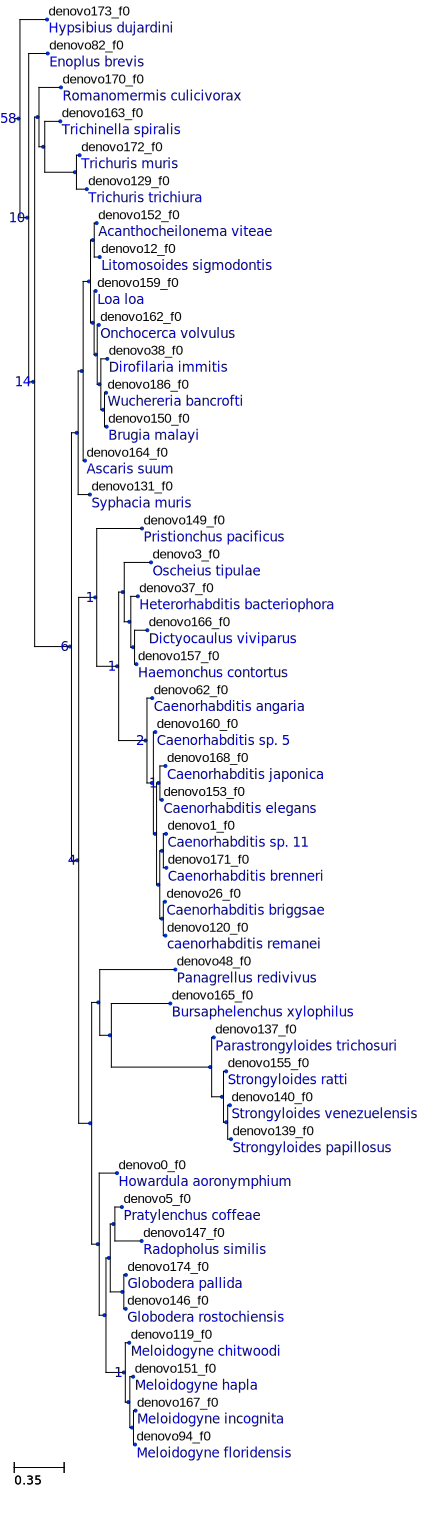

In [202]:
t.render('%%inline')